# COGS 118A - Final Project

# Multiple Object Tracking

## Group members

- Chao-Li Wei (Michael)
- Andrew Truong
- Zeyu Feng (Ted)
- Ahmad Said
- Chiadika Vincent

# Abstract 
Simultaneous tracking of multiple objects in a real-world environment has been active in the research field, even more so with the emerging popularity in the field of autonomous vehicles. The goal of our project is to perform Multiple Object Tracking (MOT) for the downsampled and subsetted BDD 100K dataset, containing over 2000 videos with 8 categories. Then, on a frame-by-frame basis, the model will predict bounding boxes to capture the objects present in the image and classify the corresponding objects. The performance will be measured by a handful of different evaluation metrics including percent accuracy and precision across all 8 categories, checking for false positives and negatives, as well as its F1 score. The main contribution of our work will be performing hyperparameter tuning on the baseline model by the competition, creating visualization to interpret the model, and performing analysis on the evaluation metrics to motivate future directions of the project.

# Background

Object tracking has been omnipotent in a variety of applications such as gesture recognizers, face identifiers, pose estimators[1], and scene analysis tools. However, for certain applications such as autonomous driving, the importance of accuracy of the model becomes especially important as tiny errors from the model can result in severe humanitarian casualties. Thus, the questions become what defines a good metric to evaluate the accuracy of the model, and what approach is plausible to push its performance.

As there has not been agreement on a set of commonly applicable metrics for MOT, we will optimize the primary metrics multiple object tracking precision (MOTP) and the multiple object tracking accuracy (MOTA) proposed by Barnardin, which allow for objective comparison of the main characteristics of tracking systems[2]. We will also use other supplementary metrics to provide a more holistic evaluation of the models.

In addition, some existing methods to perform MOT use appearance features to associate objects across different frames, for example, SiameseCNN learns the similarity between a pair of detected objects with a Siamese Network [9]. In “DEFT: Detection Embeddings for Tracking”, the researchers implement a CenterNet as the object detection module and a Deep Affinity Network as the object matching module [6]. More details are provided in the Proposed Solution section below.

For our work, we will push the performance of the baseline model FRCNN ... Ted provide citation and describe the method briefly with hyperparameter tuning. Furthermore, by performing an analysis on the various metrics and interpreting the model layers, we hope to eventually motivate future directions for this project.

# Problem Statement

The problem that we are trying to solve is multiple object tracking (MOT). Multiple object tracking can be summarized as the task of “locating multiple objects, maintaining their identities, and yielding their individual trajectories given an input video.”[3] For the BBD 100K dataset, our goal is very similar to the classic MOT task. Our goal is to predict 2D bounding boxes for objects and their association across frames in a video sequence of camera images. The camera images are frames from a video that show the view of an autonomous vehicle. The objects that we will be predicting are objects that the autonomous vehicle should detect while driving. The accuracy of our predictions will be based on many evaluation metrics like multiple object tracking accuracy (MOTA) and multiple object tracking precision (MOTP). These will be explained more in depth in our evaluation metrics section, but here’s a quick summary of each one. MOTA measures the errors from false positives, false negatives, and identity switches. On the other hand, MOTP measures the misalignments between ground-truths and detections.

# Data

To download the dataset, go to https://bdd-data.berkeley.edu/ , register for a free account and download the zip files. More instructions on parsing and installing the dataset can be found in the README file provided by BDD100K at https://github.com/SysCV/bdd100k-models/blob/main/doc/PREPARE_DATASET.md.


Since the dataset provided by BDD100K is extremely large, we will be working on a subset of the training data that contains around 200 videos. Each video is around 40 seconds long and they are annotated at 5 fps (resampled from 30 fps), resulting in approximately 200 frames/images per video and a total of around 40,000 frames/images in the training set, totaling to 80,000 when including validation images. And all the images have 1280x720 pixels. We can convert each frame/image into a 3-dimensional array(x coordinates, y coordinates and RGB values) of numbers that has a shape of 1280x720x3 using the OpenCV package in Python.


The annotations of each image contain information for the objects that should be detected and tracked at each frame. The labels for each object includes:
- `id`: Each object has an unique id, and the same object across different frames keeps the same id. 
This can help us track the same object across different frames
- `Category`: type of the object, “car” or “other vehicles”
- `box2d`: Region Of Interest(bounding boxes) of the object and their positions on the frame indicated by x1, x2, y1, and y2 values. This is another important variable that can help us track the location of the object in the image/frame
- `Attributes`
    - `Occluded`: whether the object is occluded
    - `Truncated`: whether the object is truncated



# Data Size Discussion

The data is already resampled from 5 Hz to 30 Hz by BDD100K. Furthermore, the training data is likely going to be done on a subset of the original dataset, which takes about 56 GB of storage. Currently the subset of the data we use is still about 5.6 GB. Given the size of the baseline model, running a single epoch of the data take about 4 days on a 20GB RAM CPU with Intel Core i7 processor. On the other hand, running sinlge epoch takes about 19 minutes using 2 GeForce RTX 208 GPUs. Therefore, using a GPU is strongly recommended to reproduce the results. For setting up compatible CUDA Driver and PyTorch+CUDA version, refer to [Appendix](#appendix)

# Proposed Solution

<a id='proposed_solution'></a>
We will implement the model in the publication “DEFT: Detection Embeddings for Tracking” that achieves a SOTA performance in Multiple Object Tracking<a name="deft"></a>[<sup>[4]</sup>](#deftnote). 

Multiple Object Tracking can be splitted into 2 subtasks: Object Detection and Object Matching. First we need to identify or detect the objects in each frame, and then we need to match the same object across different frames to track the motion of that object. DEFT proposes a framework that has an object detection network jointly-learned with an object matching network.
1. Use CenterNet <a name="centernet"></a>[<sup>[5]</sup>](#centernetnote) as the backbone of the object detector that takes in a frame/image and outputs a set of bounding boxes that each box contains one unique object detected from the frame/image.
2. Then we can extract feature embeddings from the objects detected in step one with convolutional layers.
3. Next we can apply a Deep Affinity Network <a name="affinity"></a>[<sup>[6]</sup>](#affinitynote) that uses the object feature embeddings from the previous step to calculate similarity scores between each pair of objects in both directions(forward:from frame t-1 to frame t; backward: from t-1 to from t). And we will create 2 matrices: A_fwd that contains similarity scores between objects in the forward direction and A_bwd that contains similarity scores between objects in the backward direction.
4. Furthermore, DEFT defines a track T that contains the associated or matched detection of an object across frames. If the similarity score between an object and a track is greater than some threshold, then that object belongs to that track. If the object has a similarity score lower than the threshold with any of the existing tracks, that means the object is new or just entered the scene, we will create a new track to store the matched association of this new object. 
5. DEFT also utilizes an LSTM module <a name="lstm"></a>[<sup>[7]</sup>](#lstmnote) for motion forecasting to filter out implausible trajectories. The LSTM module predicts the location of an object given its track of previous frames. Objects that are very far away from the predicted location will be set to have a negative similarity score with that track to remove physically impossible trajectories. 
6. For training, we will also create 2 ground truth Matching matrices. M_fwd, contains object matching information in the forward directions. M_fwd[i,j] is 1 if the ith object in the frame t-n is associated with the jth object in frame t, and 0 otherwise. M_bwd contains matching information in the backward directions.
7. Loss function:(N_t is the number of objects detected in frame t and N_{t-n} is the number of objects detected in frame t-n)
$$ L_{fwd} = \sum_i\sum_jM_{fwd}[i, j]log(A_{fwd}[i, j])$$
$$ L_{bwd} = \sum_i\sum_jM_{bwd}[i, j]log(A_{bwd}[i, j])$$
$$ L = \frac{L_{fwd} + L_{bwd}}{2(N_t + N_{t-n})}$$

Our solution will be tested and evaluated using the metrics in the [Evaluation Metrics](#evaluation_metrics) Section. It will also be compared to the benchmark model ResNet-50 that also utilizes similarity learning <a name="quasi"></a>[<sup>[8]</sup>](#quasinote). Our plan is to first reproduce the ResNet-50 benchmark model's solution. Then, we'll build our model using PyTorch-Lightning and provide ample documentations to make our code reproducible.

# Evaluation Metrics

<a id='evaluation_metrics'></a>
For this project, we will be focusing primarily on 5 evaluation metrics for our performance. The first would be multiple object tracking accuracy which would be given by the formula below
$$MOTA = 1 - \frac{\sum_t(m_t+fp_t+mme_t)}{\sum_tg_t}$$
where $m_t$, $fp_t$, and $mme_t$ are the number of misses, false positives, and of mismatches respectively for time t, while $g_t$ is the total number of objects present in all frames. The second would be multiple object tracking precision, given by the equation below
$$MOTP = \frac{\sum_{i, t}d_{i, t}}{\sum_{t}c_{t}}$$
where $d_t$ is the distance between the localization of objects in the ground truth and the detection output and $c_t$ is the total matches made between ground truth and the detection output. We will also be checking for the amount of false positives and false negatives we obtain as well as calculating our F1 score which combines the precision and recall of a classifier into a single metric by taking their harmonic mean.

In [1]:
{
    "tags": [
        "hide-cell",
    ]
}

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

logs = ['./reports/logs/lr_0.01/20220601_062727.log.json',
        './reports/logs/lr_0.005/20220530_031244.log.json',
        './reports/logs/lr_0.0025/20220603_213830.log.json',
        './reports/logs/lr_0.00125/20220605_174145.log.json',
        './reports/logs/lr_0.000625/20220607_162145.log.json']
        
learning_rates = ['0.01', '0.005', '0.0025', '0.00125', '0.000625']

temp = [] # temporary list of dataframes
for log, learning_rate in zip(logs, learning_rates):
    data = pd.read_json(log, lines=True)
    data['learning_rate'] = learning_rate # add learning rate column
    temp.append(data) 

temp = pd.concat(temp, ignore_index=True) # combines list of dataframes
df = temp[temp.isnull().sum(axis=1) < 24] # removes the first line of each json which contains the environmental info and seed

# Validation data only has secondary metrics (i.e precision, recall, etc), but training data only has loss (loss_rpn_cls, etc)
val_df = df[df['mode'] == 'val']
val_df = val_df.dropna(axis=1)
train_df = df[df['mode'] == 'train']
train_df = train_df.dropna(axis=1)

def create_line_plots(data, x_axis, metrics, ncols=2, figsize=(16,9)):
    nrows = int(len(metrics)/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    for metric, ax in zip(metrics, axes.ravel()):
        sns.lineplot(x=x_axis, y=metric, hue='learning_rate', data=data, ax=ax, legend=False)
        ax.set_title('Epoch vs. {}'.format(metric))
    fig.legend(labels = learning_rates, title='learning rate', bbox_to_anchor=(1.1,1))

def create_box_plots(data, x_axis, metrics, ncols=2, figsize=(16,9)):
    nrows = int(len(metrics)/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    for metric, ax in zip(metrics, axes.ravel()):
        sns.boxplot(x=x_axis, y=metric, data=data, ax=ax)
        ax.set_xlabel('learning rate')
        ax.set_title('Learning Rate vs. {}'.format(metric))

def create_scatter_plots(data, metrics, ncols=2, figsize=(16,9)):
    nrows = int(len(metrics)/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    for metric, ax in zip(metrics, axes.ravel()):
        sns.scatterplot(x=x_axis, y=metric, hue='epoch', data=data, ax=ax, legend=True)
        ax.set_title('Learning Rate vs. {}'.format(metric))
    fig.legend(labels = ['2', '4', '6', '8', '10', '12'], title='epoch', bbox_to_anchor=(1.08,1))
    for ax in axes.ravel():
        ax.legend_.remove()

## Subsection 1

In [7]:
#code cell for subsection 1

## Subsection 2

In [8]:
# code cell for subsection 2

## Subsection 3

<h1 align="center">False Negative and False Positive Plots</h1> 

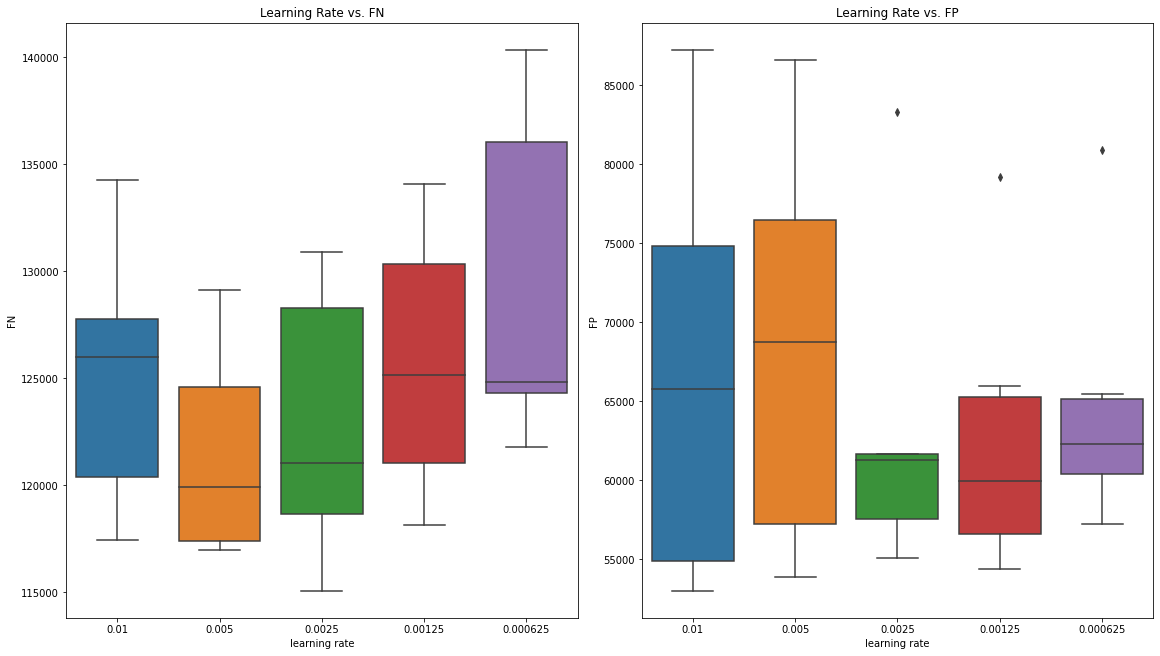

In [11]:
x_axis = 'learning_rate'
create_box_plots(data=val_df, x_axis=x_axis, metrics=['FN','FP'], ncols=2, figsize=(16,9))

## FN and FP
As you can see above a learning rate of 0.005 minimized false negatives while simultaneously also having the largest amount of false positives. But since we want to minimize collisions with cars and also collisions with other people on the road. We believe that recall is a much better metric in this case. And since .005 also leads in that metric with 0.73. Then it is probably a better learning rate with this data for the purpose of not missing important information in the road

<h1 align="center">Recall and Precision Plots</h1> 

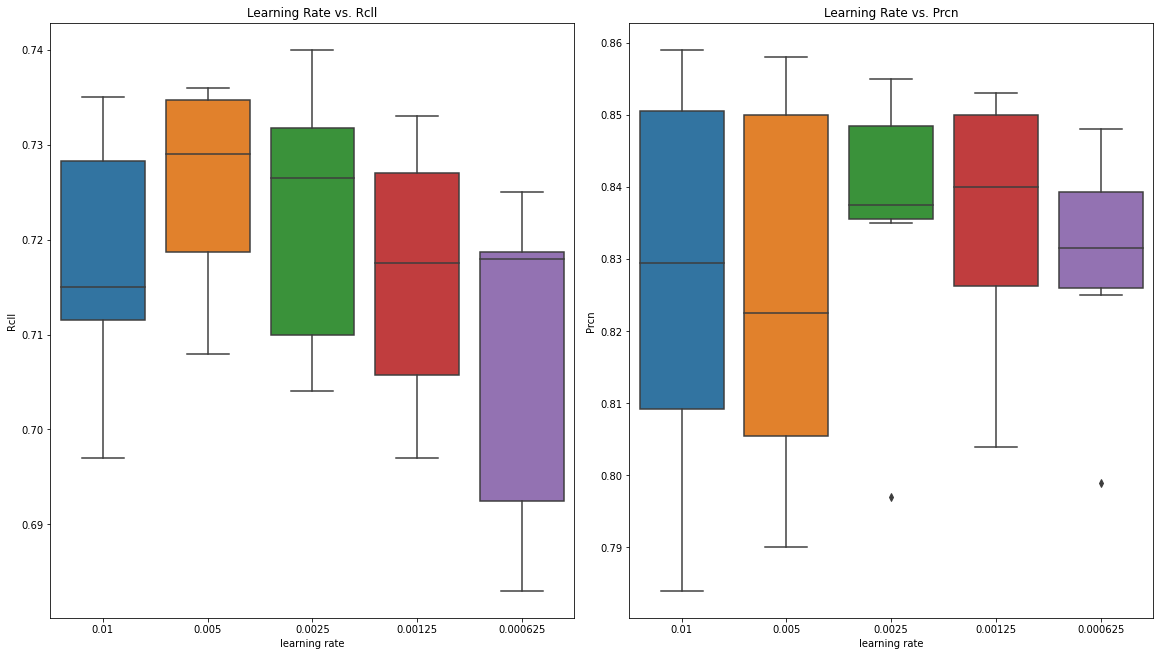

In [17]:
x_axis = 'learning_rate'
create_box_plots(data=val_df, x_axis=x_axis, metrics=['Rcll','Prcn'], ncols=2, figsize=(16,9))

## Recall and Precision Analysis
### Recall
Recall is the left most graph and it peaks in the 0.005 learning rate and then goes down when learning rate is either increased or decreased. From the analysis from before we believe that Recall is most important because we want to avoid false negatives and not seeing other cars/pedestrians. But in the long terms the values of both precision and recall are really all within a couple percent but across the 40,000 validation images that does come up to a significant number. And in the case of maximizing recall, it may even save lives.

## Subsection 4

<h1 align="center">MT PT ML FM Plots</h1> 

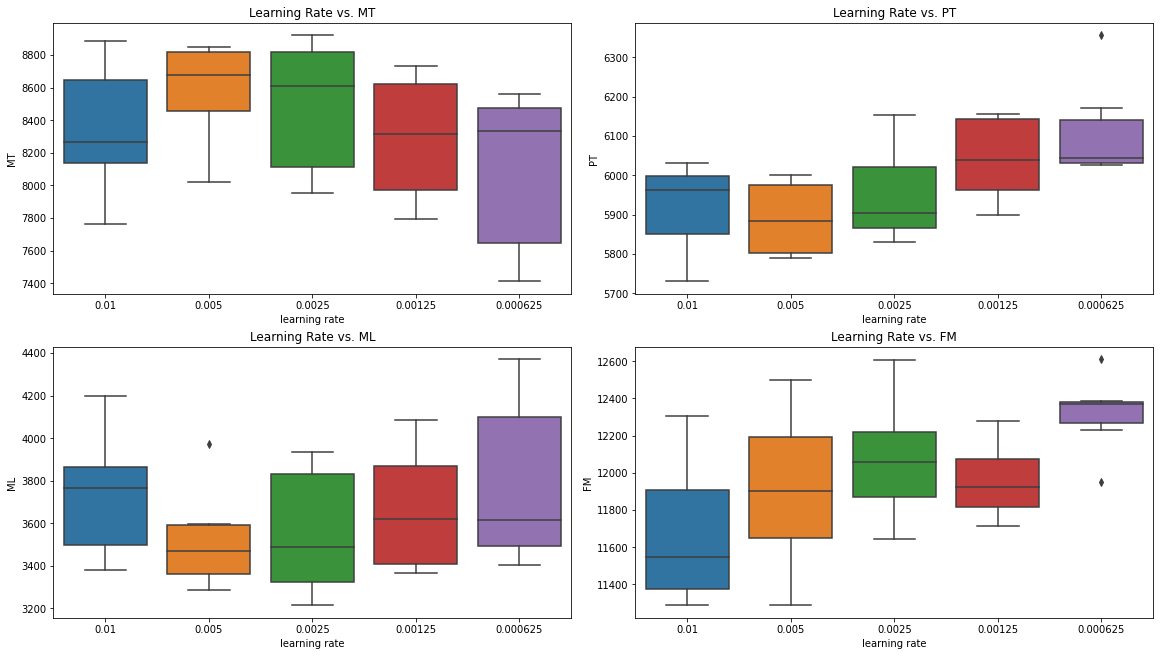

In [12]:
x_axis = 'learning_rate'
create_box_plots(data=val_df, x_axis=x_axis, metrics=['MT','PT','ML','FM'], ncols=2, figsize=(16,9))

### From above we can look at each plot separately and describe each metric and how each learning rate affected our results. 

## MT 
MT stands for mostly tracked and it means that at least 80 percent of the lifespan of the vehicle was tracked. This was led by a learning rate of 0.005 and shows that once it identified an object it didn't seem to lose track of it and was not prone to suddenly losing track of something. 

## PT
PT looks at objects that were tracked between 20 to 80% of their lifespan, and stands for partially tracked. While looking at the PT graph, the learning rate of 0.005 was the worst compared to the rest of the learning rates. This makes sense due to it tracking more objects in MT. But the metric itself is way too vast to be meaningful since if the average for most tracked objects was around 30% then that means almost 2/3 of the time, something was not seen. While another learning rate could have an average of 60% of their lifespan but have a lower PT score which is why the gap from 20 to 80% seems too big and meaningless.

## ML
ML stands for mostly lost, and includes everything else we have not covered above. Which means everything tracked for less than 20% of its lifespan. And here most learning rates really hovered around the same sort of number except for .01 which was a good amount higher than the rest. But for real life applications, tracking something for less than 20% of its life is mostly meaningless, but still provides a glimmer that maybe with more training or optimizations those are all possible objects that can hopefully be detected with more work.

## FM
FM as a metric is Number of fragmentations where it is the number of times something switched from being tracked to not being tracked. Here .01 performed the best and .000625 was the worst. This means that a far lower learning rate made the network have less experience with tracking and that it probably did not have enough confidence to know how vehicles move.

# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points. You probably want 2-5 sentences per point.

### Limitations

Our biggest limitation was how computationally expensive it was to train our models. Given that we were working with object tracking, we needed a large set of data to be able to get meaningful results from our model. However, this meant that it would take days for us to be able to retrain our models after making any changes. This slowed down our process due to the amount of time it took to impliment new changes. 

### Ethics & Privacy

For ethics and privacy, we are using a dataset of drivable environments that an autonomous vehicle would see, in it we will be encountering other cars, pedestrians, street signs, bikes and buildings. One privacy concern is that it will obviously have the faces and appearances of people around where the driving data was taken, but we are not specifically doing facial recognition and we will not make out who or what the person looks like crossing the road. All we’ll be doing is seeing if it is a person or not, therefore ignoring the individual identity of the person. Considering we keep our code hidden and only have a trained model, people will also not be able to identify pedestrians’ faces unless they themselves go and do it but considering how hard it is to identify faces from our dataset, we do not believe it is of much concern.

Also ethically, our solution could make mistakes and mislabel a pedestrian crossing a street as a lightpost or a stationary object or not even see it and accidently hit it. We can only address these issues by making sure that our model does not make many of these mistakes. But these are extremely rare and just our solution would not be used in guiding an autonomous vehicle. Autonomous vehicles usually come equipped with LIDAR/RADAR and have a pipeline of image processing to make sure it does not make mistakes in labeling people. So there will be many redundancies in case we mislabel a pedestrian.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="posenote"></a>1.[^](#pose): M. Voit, K. Nickel, and R. Stiefelhagen, “Multi-view head pose estimation using neural networks,” in Proceedings of the 2nd Workshop on Face Processing in Video (FPiV ’05), in association with the 2nd IEEE Canadian Conference on Computer and Robot Vision (CRV ’05), pp. 347–352, Victoria, Canada, May 2005. https://doi.org/10.1007/978-3-540-69568-4_26 <br>
<a name="motanote"></a>2.[^](#mota): Bernardin. (2008) Evaluating Multiple Object Tracking Performance: The CLEAR MOT Metrics. https://link.springer.com/article/10.1155/2008/246309 <br>
<a name="motnote"></a>3.[^](#mot):Luo, Wenhan, et al. "Multiple object tracking: A literature review." Artificial Intelligence 293 (2021): 103448. https://arxiv.org/abs/1409.7618<br>
<a name="deftnote"></a>4.[^](#deft): Chaabane, Mohamed, et al. "Deft: Detection embeddings for tracking." arXiv preprint arXiv:2102.02267 (2021). https://arxiv.org/abs/2102.02267<br>
<a name="centernetnote"></a>5.[^](#centernet): Zhou, Xingyi, Dequan Wang, and Philipp Krähenbühl. "Objects as points." arXiv preprint arXiv:1904.07850 (2019). https://arxiv.org/abs/1904.07850<br>
<a name="affinitynote"></a>6.[^](#affinity): Sun, ShiJie, et al. "Deep affinity network for multiple object tracking." IEEE transactions on pattern analysis and machine intelligence 43.1 (2019): 104-119. https://arxiv.org/abs/1810.11780<br>
<a name="lstmnote"></a>7.[^](#lstm): Sadeghian, Amir, Alexandre Alahi, and Silvio Savarese. "Tracking the untrackable: Learning to track multiple cues with long-term dependencies." Proceedings of the IEEE international conference on computer vision. 2017. https://arxiv.org/abs/1701.01909<br>
<a name="quasinote"></a>8.[^](#quasi): Pang, Jiangmiao, et al. "Quasi-dense similarity learning for multiple object tracking." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2021. https://arxiv.org/abs/2006.06664<br>
<a name="siamesenote"></a>9.[^](#siamese): He, Anfeng, et al. "A twofold siamese network for real-time object tracking." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018. https://arxiv.org/abs/1802.08817v1<br>